## Cross Validation Test for LightGBM

In [83]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import datetime
import missingno as msno
import lightgbm as lgb
import xgboost as xgb
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, TimeSeriesSplit, train_test_split,StratifiedKFold
import gc
from statistics import mean

# Any results you write to the current directory are saved as output.

### Setup Cross Validation
1. Divide Train set in subsets (Training set itself + Local Test set)
2. Define Validation Metric (in our case it is ROC-AUC)
3. Stop training when Validation metric stops improving
4. Take average of each fold's prediction for the Local Test set.

In [77]:
train_full = pd.read_pickle('data/train_full.pkl')
test_full = pd.read_pickle('data/test_full.pkl')

train_full=train_full.sort_values('TransactionDT',ascending=True).reset_index(drop=True)


In [78]:
# Label Encoding
for f in test_full.columns:
    if train_full[f].dtype=='object' or test_full[f].dtype=='object': 
        train_full[f] = train_full[f].fillna('unseen_before_label')
        test_full[f]  = test_full[f].fillna('unseen_before_label')
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_full[f].values) + list(test_full[f].values))
        train_full[f] = lbl.transform(list(train_full[f].values))
        test_full[f] = lbl.transform(list(test_full[f].values)) 
        
train_full = train_full.fillna(-999)
test_full = test_full.fillna(-999)

In [79]:
rm_cols = [
    'TransactionID','TransactionDT', 
    'isFraud'                         
]

# Final features
features_columns = [col for col in list(train_full.columns) if col not in rm_cols]

In [80]:
# X = train_full[features_columns]
# y = train_full['isFraud']

# Split holdout as 15% of the train set
X, X_holdout, y, y_holdout = train_test_split(train_full[features_columns], train_full['isFraud'], 
                                              test_size=0.15, random_state=42, shuffle=True,
                                              stratify = train_full['isFraud'])

del train_full
gc.collect()

205

In [81]:
# params = {
#                     'objective':'binary',
#                     'boosting_type':'gbdt',
#                     'metric':'auc',
#                     'n_jobs':-1,
#                     'learning_rate':0.01,
#                     'num_leaves': 2**8,
#                     'max_depth':-1,
#                     'tree_learner':'serial',
#                     'colsample_bytree': 0.7,
#                     'subsample_freq':1,
#                     'subsample':0.7,
#                     'n_estimators':10000,
#                     'max_bin':255,
#                     'verbose':-1,
#                     'seed': 2019,
#                     'early_stopping_rounds':100, 
#                 } 

params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.05, # speed up the learning rate a bit - might sacrifice a bit of accuracy
                    'num_leaves':2**8, # reduce number of leaves to reduce overfitting
                    'max_depth': 8, # max_depth should be constrained, -1 would mean unconstrained
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'n_estimators':1000,
                    'max_bin':255, # less bins if overfitting
                    'verbose':-1,
                    'seed': 2019,
                    'early_stopping_rounds':100,
#                     'lambda_l1':5,
#                     'lambda_l2':5,
                } 

In [84]:
NFOLDS =5
folds = StratifiedKFold(n_splits=NFOLDS,random_state=123,shuffle=True) # split by stratified folds
# folds = TimeSeriesSplit(n_splits=NFOLDS) # split by time - try timeseries split, perhaps less overfitting? result: worse overfitting

aucs = []
clfs=[]
pred_len = len(test_full)
prediction = np.zeros(pred_len)

for fold, (trn_idx, test_idx) in enumerate(folds.split(X,y)):
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(data=X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(data=X.iloc[test_idx], label=y.iloc[test_idx])
    clf = lgb.train(params, 
                    trn_data, 
                    valid_sets = [trn_data, val_data], 
                    verbose_eval=200)
    
    print('AUC for validation fold {}: {}'.format(fold+1, clf.best_score['valid_1']['auc']))
    aucs.append(clf.best_score['valid_1']['auc'])
    
    holdout_pred = clf.predict(X_holdout)
    print('AUC for holdout set - fold ', roc_auc_score(y_holdout, holdout_pred))
    
    prediction += clf.predict(test_full[features_columns])

print("Cross Validation AUC: ", sum(aucs)/NFOLDS)
final_predictions = prediction/NFOLDS

Training on fold 1


C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.968026	valid_1's auc: 0.942312
[400]	training's auc: 0.982663	valid_1's auc: 0.952393
[600]	training's auc: 0.990142	valid_1's auc: 0.957963
[800]	training's auc: 0.994581	valid_1's auc: 0.961405
[1000]	training's auc: 0.996991	valid_1's auc: 0.963803
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.996991	valid_1's auc: 0.963803
AUC for validation fold 1: 0.9638026225776628
AUC for holdout set - fold  0.9674592098550717
Training on fold 2


C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.967428	valid_1's auc: 0.941618
[400]	training's auc: 0.982487	valid_1's auc: 0.953128
[600]	training's auc: 0.990298	valid_1's auc: 0.95912
[800]	training's auc: 0.994436	valid_1's auc: 0.962861
[1000]	training's auc: 0.996821	valid_1's auc: 0.964857
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.996821	valid_1's auc: 0.964857
AUC for validation fold 2: 0.9648571850599834
AUC for holdout set - fold  0.9659637060340159
Training on fold 3


C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.965919	valid_1's auc: 0.939227
[400]	training's auc: 0.982124	valid_1's auc: 0.951196
[600]	training's auc: 0.990082	valid_1's auc: 0.956575
[800]	training's auc: 0.994547	valid_1's auc: 0.960608
[1000]	training's auc: 0.997086	valid_1's auc: 0.962744
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.997086	valid_1's auc: 0.962744
AUC for validation fold 3: 0.9627437305494932
AUC for holdout set - fold  0.9652901343926326
Training on fold 4


C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.966877	valid_1's auc: 0.941255
[400]	training's auc: 0.982324	valid_1's auc: 0.95281
[600]	training's auc: 0.989996	valid_1's auc: 0.958903
[800]	training's auc: 0.994289	valid_1's auc: 0.96238
[1000]	training's auc: 0.996742	valid_1's auc: 0.965031
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.996742	valid_1's auc: 0.965031
AUC for validation fold 4: 0.9650306034249508
AUC for holdout set - fold  0.9658678164000627
Training on fold 5


C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.966543	valid_1's auc: 0.943417
[400]	training's auc: 0.982958	valid_1's auc: 0.956041
[600]	training's auc: 0.990503	valid_1's auc: 0.961604
[800]	training's auc: 0.994712	valid_1's auc: 0.964903
[1000]	training's auc: 0.996921	valid_1's auc: 0.966724
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.996921	valid_1's auc: 0.966724
AUC for validation fold 5: 0.9667236989212361
AUC for holdout set - fold  0.9665139182018161
Cross Validation AUC:  0.9646315681066653


The average AUC for the timeseries split is much lower, and the LB score is a lower too. Might not be the correct CV scheme for time series as well. Still inconclusive

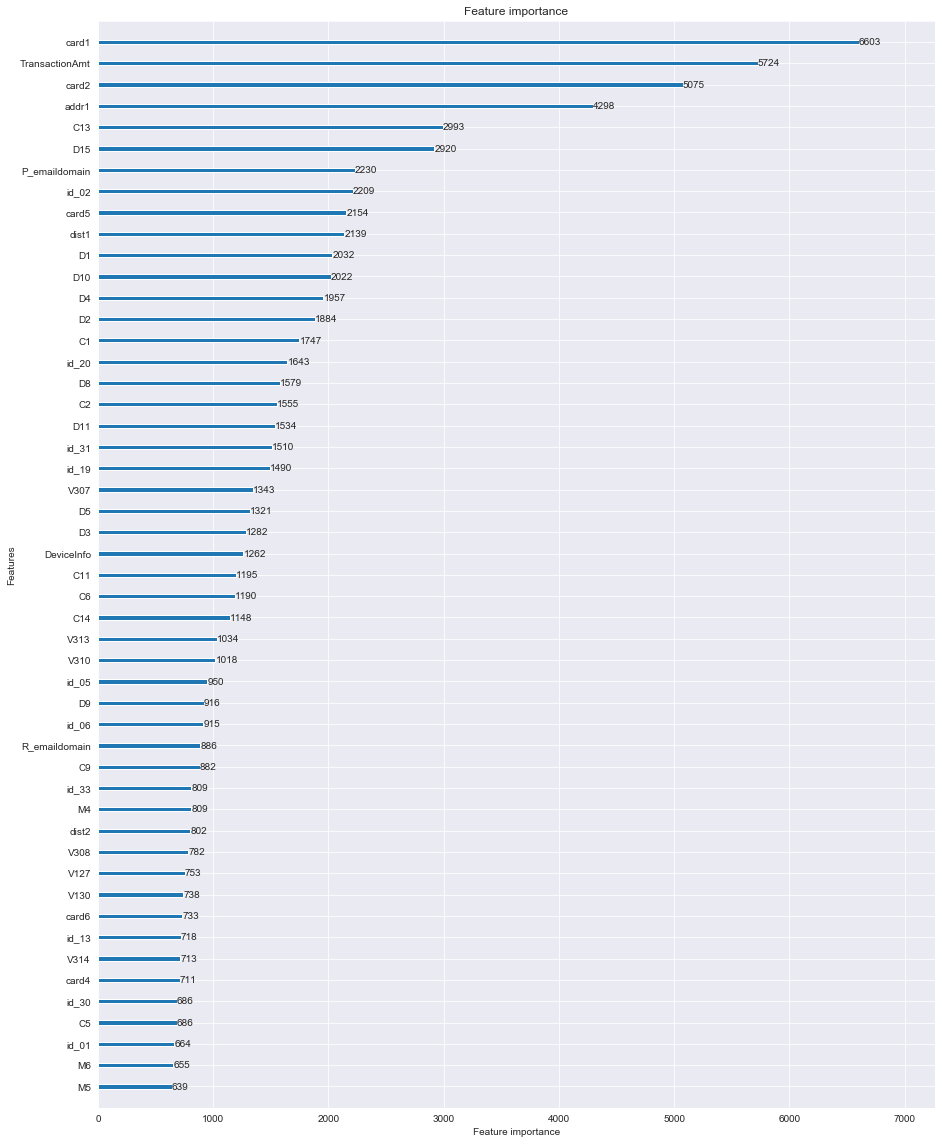

In [85]:
fig, ax = plt.subplots(figsize=(15, 20))
lgb.plot_importance(clf,max_num_features=50,ax=ax)
# for i in range(NFOLDS):
#     fig, ax = plt.subplots(figsize=(15, 20))
#     xgb.plot_importance(clfs[i],max_num_features=50,ax=ax)

In [86]:
sample_submission = pd.read_csv('data/sample_submission.csv', index_col='TransactionID')
sample_submission['isFraud'] = prediction
sample_submission.to_csv('data/lightgbm_cv.csv')

### Feature Engineering
- build time of day/ week, month features (D9 is already a time of day feature, but because it has alot of NAs, better to create using the timedelta variable)
- Hour and TransactionPerHour

In [ ]:
# # Time dependent features
# # https://www.kaggle.com/fchmiel/day-and-time-powerful-predictive-feature
# train_full['Transaction_day_of_week'] = np.floor((train_full['TransactionDT'] / (3600 * 24) - 1) % 7)
# test_full['Transaction_day_of_week'] = np.floor((test_full['TransactionDT'] / (3600 * 24) - 1) % 7)
# train_full['Transaction_hour'] = np.floor(train_full['TransactionDT'] / 3600) % 24
# test_full['Transaction_hour'] = np.floor(test_full['TransactionDT'] / 3600) % 24